In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Load Data

In [0]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('/content/drive/My Drive/Deep Learning/Final Project/dataset/qa_Health_and_Personal_Care.json').read()

data_file = data_file.split("\n")
data_file = data_file[:80496]

a = 0
l = []
for i in data_file:
  a = a+1
  l.append(eval(i))

data_file = {"intents":l}

intents = json.loads(json.dumps(data_file))

In [4]:
intents

{'intents': [{'answer': 'here are 3 norelco shavers this fits: 715 RL, 725 RL, 6940LC',
   'answerTime': 'Dec 20, 2013',
   'asin': '7293000154',
   'question': 'which model Norelcos does it fit?',
   'questionType': 'open-ended',
   'unixTime': 1387526400},
  {'answer': 'The best I can do from the info from Norelco is an HQ9.',
   'answerTime': 'May 27, 2014',
   'asin': '7293000154',
   'question': 'What replacement blades do I use for my 5801XL razor? It was a GQ9',
   'questionType': 'open-ended',
   'unixTime': 1401174000},
  {'answer': 'Yes and they work great.each set last me one year.',
   'answerTime': 'Jun 7, 2014',
   'answerType': 'Y',
   'asin': '7293000154',
   'question': 'are these made by philips norelco?',
   'questionType': 'yes/no',
   'unixTime': 1402124400},
  {'answer': 'yes',
   'answerTime': 'Apr 15, 2014',
   'asin': '7293000154',
   'question': 'I have a philips HQ 6695 does it fit?',
   'questionType': 'open-ended',
   'unixTime': 1397545200},
  {'answer': "

## EDA

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
question = []
answer = []
classes = []


for intent in intents['intents']:
  question.append(intent['question'])
  answer.append(intent['answer'])
  # set yes/no as 1 and open-ended as 0
  if intent['questionType'] =='yes/no':
    classes.append(1)
  else:
    classes.append(0)

In [0]:
question_len = []
answer_len = []

for q in question:
  question_len.append(len(q))

for a in answer:
  answer_len.append(len(a))

(array([ 1150.,  9525., 15580., 11976.,  8941.,  6770.,  5331.,  4524.,
         3902.,  3642.,  4125.,  4155.,   185.,   141.,   114.,    69.,
           52.,    58.,    39.,   217.]),
 array([  1.,  14.,  27.,  40.,  53.,  66.,  79.,  92., 105., 118., 131.,
        144., 157., 170., 183., 196., 209., 222., 235., 248., 261.]),
 <a list of 20 Patch objects>)

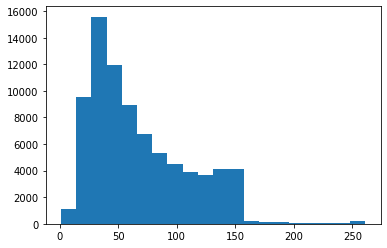

In [14]:
# Question lenghth
import matplotlib.pyplot as plt

plt.hist(question_len,bins=20)

In [17]:
max(answer_len)

14433

(array([7.242e+03, 5.377e+03, 5.631e+03, 5.659e+03, 5.180e+03, 4.943e+03,
        4.567e+03, 4.138e+03, 3.621e+03, 3.375e+03, 2.950e+03, 2.611e+03,
        2.424e+03, 2.105e+03, 1.961e+03, 1.692e+03, 1.492e+03, 1.446e+03,
        1.271e+03, 1.092e+03, 9.410e+02, 9.300e+02, 6.940e+02, 7.240e+02,
        6.960e+02, 6.090e+02, 5.410e+02, 4.730e+02, 4.340e+02, 3.830e+02,
        3.820e+02, 3.910e+02, 3.020e+02, 2.600e+02, 2.340e+02, 2.190e+02,
        1.800e+02, 1.780e+02, 2.200e+02, 1.570e+02, 1.370e+02, 1.690e+02,
        1.290e+02, 1.380e+02, 1.600e+02, 1.180e+02, 9.000e+01, 1.030e+02,
        9.000e+01, 7.500e+01, 7.700e+01, 7.600e+01, 5.700e+01, 6.100e+01,
        7.100e+01, 4.400e+01, 4.200e+01, 3.800e+01, 5.400e+01, 3.800e+01,
        5.300e+01, 4.600e+01, 2.700e+01, 4.100e+01, 4.000e+01, 3.000e+01,
        3.800e+01, 3.200e+01, 2.800e+01, 2.000e+01, 3.000e+01, 2.600e+01,
        1.600e+01, 2.400e+01, 2.100e+01, 2.500e+01, 1.500e+01, 1.000e+01,
        1.300e+01, 2.700e+01, 8.000e+0

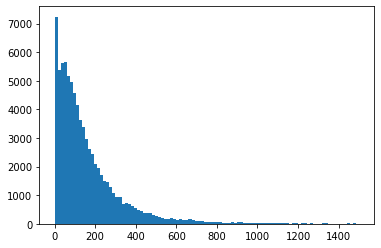

In [20]:
# Answer lenghth
# We have extrem values, so cut off at 1500
plt.hist(answer_len,bins=100,range=(0,1500))

(array([47063.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 33433.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

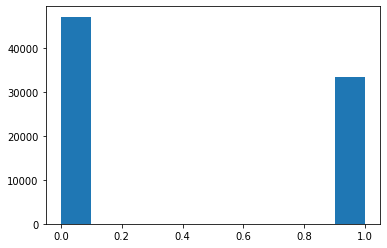

In [23]:
plt.hist(classes)

In [26]:
import pandas as pd
pd.Series(classes).value_counts()

0    47063
1    33433
dtype: int64

## Preprocessing Data

In [0]:
shape0 = np.array(question).shape
shape1 = np.array(answer).shape
shape2 = np.array(classes).shape
#cheack the shape of dataset
print(shape0, shape1, shape2)

(80496,) (80496,) (80496,)


In [0]:
# Tokenize, pad and prepare training and validation data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 30  # cut the question after 30 words
training_samples = 30000 # we will be training on 30000 samples
validation_samples = 30000 # we will be validating on 30000 samples
test_samples = 20496 # we will be testing on 20496 samples
max_words = 10000 # we will only consider the top 10,000 words in a questions

In [0]:
# to vectorize a text corpus, by turning each text into either a sequence of integers or omit common characters
tokenizer = Tokenizer(num_words=max_words)

# fit_on_texts means it learns the indices of the words
tokenizer.fit_on_texts(question)

# the sequences are comprised of those indices
sequences = tokenizer.texts_to_sequences(question)

word_index = tokenizer.word_index
print('Found %s unique tokens' %len(word_index))

# pad sequences
data = pad_sequences(sequences, maxlen=maxlen)

classes = np.asarray(classes)
print('shape of data tensor:',data.shape)
print('shape of label tensor:',classes.shape)

Found 27807 unique tokens
shape of data tensor: (80496, 30)
shape of label tensor: (80496,)


In [0]:
# split the data into training data, validation data and test data.
# first shuffle the data and labels together
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
classes = classes[indices]

x_train = data[:training_samples]
y_train = classes[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = classes[training_samples:training_samples+validation_samples]
x_test = data[training_samples+validation_samples:training_samples+test_samples+validation_samples]
y_test = classes[training_samples+validation_samples:training_samples+test_samples+validation_samples]

In [0]:
x_test.shape

(20496, 30)

## Modeling

In [0]:
import os

# Start fitting models
# For example, LSTM, Bidirectional, 1D conv.
# Show plots of the results for each model

glove_dir = '/content/drive/My Drive/Deep Learning/week 4/Glove embeddings'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100 # this is the dimension of the file we imported
# could use 50, but need to make sure you 

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Model 1

In [0]:
import tensorflow as tf

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model1.add(tf.keras.layers.LSTM(50))
model1.add(tf.keras.layers.Dense(32, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,031,865
Trainable params: 1,031,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.layers[0].set_weights([embedding_matrix])
model1.layers[0].trainable = False

In [0]:
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history1 = model1.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

#model1.save('/content/drive/My Drive/Colab Notebooks/DeepLearning/Project/Chatbot_Model.h5', history1)

Epoch 1/10
938/938 [==============================] - 42s 45ms/step - loss: 0.3774 - acc: 0.8255 - val_loss: 0.3439 - val_acc: 0.8488
Epoch 2/10
938/938 [==============================] - 24s 25ms/step - loss: 0.2556 - acc: 0.8906 - val_loss: 0.2299 - val_acc: 0.8997
Epoch 3/10
938/938 [==============================] - 21s 23ms/step - loss: 0.2282 - acc: 0.9046 - val_loss: 0.2163 - val_acc: 0.9118
Epoch 4/10
938/938 [==============================] - 23s 24ms/step - loss: 0.2121 - acc: 0.9122 - val_loss: 0.2156 - val_acc: 0.9105
Epoch 5/10
938/938 [==============================] - 22s 24ms/step - loss: 0.1965 - acc: 0.9190 - val_loss: 0.2011 - val_acc: 0.9196
Epoch 6/10
938/938 [==============================] - 24s 25ms/step - loss: 0.1858 - acc: 0.9244 - val_loss: 0.1985 - val_acc: 0.9211
Epoch 7/10
938/938 [==============================] - 25s 27ms/step - loss: 0.1744 - acc: 0.9309 - val_loss: 0.1980 - val_acc: 0.9225
Epoch 8/10
938/938 [==============================] - 23s 24ms

In [0]:
model1.save('/content/drive/My Drive/Deep Learning/FinalAssign/Chatbot_Model1.h5', history1)

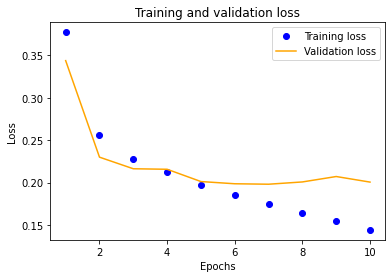

In [0]:
# see the training and validation loss by epoch
history_dict1 = history1.history
loss_values1 = history_dict1['loss'] # you can change this
val_loss_values1 = history_dict1['val_loss'] # you can also change this
epochs1 = range(1, len(loss_values1) + 1) #acc wasn't defined before
plt.plot(epochs1, loss_values1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss_values1, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

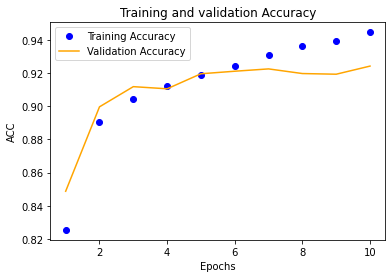

In [0]:
# see the training and validation accuracy by epoch
history_dict1 = history1.history
acc_values1 = history_dict1['acc'] # you can change this
val_acc_values1 = history_dict1['val_acc'] # you can also change this
epochs1 = range(1, len(acc_values1) + 1) #acc wasn't defined before
plt.plot(epochs1, acc_values1, 'bo', label='Training Accuracy')
plt.plot(epochs1, val_acc_values1, 'orange', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

#### Model 1: Validation Data Result

In [0]:
preds_val = model1.predict(x_val)
# Cut-off Value = 0.5
for i in range(len(preds_val)):
  if preds_val[i]>0.5:
    preds_val[i] = 1
  else:
    preds_val[i] = 0

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print('Val Confusion Matrix')
confusion_matrix(y_val, preds_val)

Val Confusion Matrix


array([[16568,  1005],
       [ 1268, 11159]])

In [0]:
print(classification_report(y_val, preds_val))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     17573
           1       0.92      0.90      0.91     12427

    accuracy                           0.92     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       0.92      0.92      0.92     30000



#### Model 1: Test Data Result

In [0]:
preds_test = model1.predict(x_test)
# Cut-off Value = 0.5
for i in range(len(preds_test)):
  if preds_test[i]>0.5:
    preds_test[i] = 1
  else:
    preds_test[i] = 0

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print('Test Confusion Matrix')
confusion_matrix(y_test, preds_test)

Test Confusion Matrix


array([[11338,   655],
       [  878,  7625]])

In [0]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     11993
           1       0.92      0.90      0.91      8503

    accuracy                           0.93     20496
   macro avg       0.92      0.92      0.92     20496
weighted avg       0.93      0.93      0.93     20496



### Model 2

In [0]:
import tensorflow as tf

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(tf.keras.layers.LSTM(32,return_sequences=True))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.GRU(16))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(20, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            17024     
_________________________________________________________________
dropout (Dropout)            (None, 30, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 16)                2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                340       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [0]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

In [0]:
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

#model2.save('/content/drive/My Drive/Colab Notebooks/DeepLearning/Project', history2)

Epoch 1/10
938/938 [==============================] - 51s 54ms/step - loss: 0.3961 - acc: 0.8157 - val_loss: 0.2523 - val_acc: 0.8900
Epoch 2/10
938/938 [==============================] - 47s 50ms/step - loss: 0.2592 - acc: 0.8894 - val_loss: 0.2234 - val_acc: 0.9063
Epoch 3/10
938/938 [==============================] - 33s 36ms/step - loss: 0.2344 - acc: 0.9013 - val_loss: 0.2122 - val_acc: 0.9122
Epoch 4/10
938/938 [==============================] - 36s 38ms/step - loss: 0.2176 - acc: 0.9103 - val_loss: 0.2106 - val_acc: 0.9155
Epoch 5/10
938/938 [==============================] - 43s 45ms/step - loss: 0.2030 - acc: 0.9180 - val_loss: 0.1926 - val_acc: 0.9217
Epoch 6/10
938/938 [==============================] - 36s 38ms/step - loss: 0.1928 - acc: 0.9251 - val_loss: 0.1919 - val_acc: 0.9235
Epoch 7/10
938/938 [==============================] - 32s 34ms/step - loss: 0.1826 - acc: 0.9297 - val_loss: 0.1944 - val_acc: 0.9199
Epoch 8/10
938/938 [==============================] - 33s 35ms

In [0]:
model2.save('/content/drive/My Drive/Deep Learning/FinalAssign/Chatbot_Model2.h5', history2)

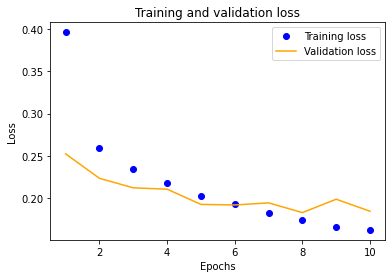

In [0]:
# see the training and validation loss by epoch
history_dict2 = history2.history
loss_values2 = history_dict2['loss'] # you can change this
val_loss_values2 = history_dict2['val_loss'] # you can also change this
epochs2 = range(1, len(loss_values2) + 1) #acc wasn't defined before
plt.plot(epochs2, loss_values2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

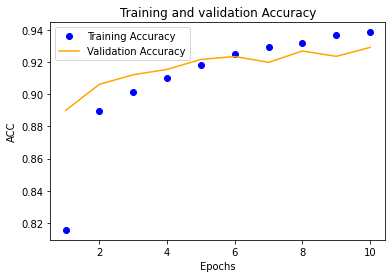

In [0]:
# see the training and validation accuracy by epoch
history_dict2 = history2.history
acc_values2 = history_dict2['acc'] # you can change this
val_acc_values2 = history_dict2['val_acc'] # you can also change this
epochs2 = range(1, len(acc_values2) + 1) #acc wasn't defined before
plt.plot(epochs2, acc_values2, 'bo', label='Training Accuracy')
plt.plot(epochs2, val_acc_values2, 'orange', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

#### Model 2 : Validation Data Results

In [0]:
preds_val2 = model2.predict(x_val)
# Cut-off Value = 0.5
for i in range(len(preds_val2)):
  if preds_val2[i]>0.5:
    preds_val2[i] = 1
  else:
    preds_val2[i] = 0

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print('Validation data Confusion Matrix')
confusion_matrix(y_val, preds_val2)

Validation data Confusion Matrix


array([[16644,   929],
       [ 1195, 11232]])

In [0]:
print(classification_report(y_val, preds_val))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     17573
           1       0.92      0.90      0.91     12427

    accuracy                           0.92     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       0.92      0.92      0.92     30000



#### Model 2: Test Data Results


In [0]:
preds_test2 = model2.predict(x_test)
# Cut-off Value = 0.5
for i in range(len(preds_test2)):
  if preds_test2[i]>0.5:
    preds_test2[i] = 1
  else:
    preds_test2[i] = 0

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print('Test Confusion Matrix')
confusion_matrix(y_test, preds_test2)

Test Confusion Matrix


array([[11338,   655],
       [  849,  7654]])

In [0]:
print(classification_report(y_test, preds_test2))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     11993
           1       0.92      0.90      0.91      8503

    accuracy                           0.93     20496
   macro avg       0.93      0.92      0.92     20496
weighted avg       0.93      0.93      0.93     20496



## Model 3

In [0]:
import tensorflow as tf

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.LSTM(32, return_sequences=True))
model3.add(tf.keras.layers.Dropout(0.2))
#model3.add(tf.keras.layers.GRU(16, return_sequences=True))
#model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.LSTM(8))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model1.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,031,865
Trainable params: 31,865
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = False

In [0]:
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history3 = model3.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model3.save('/content/drive/My Drive/Deep Learning/FinalAssign/Chatbot_Model3.h5', history3)

Epoch 1/10
938/938 [==============================] - 56s 59ms/step - loss: 0.4492 - acc: 0.7804 - val_loss: 0.3027 - val_acc: 0.8709
Epoch 2/10
938/938 [==============================] - 37s 39ms/step - loss: 0.3019 - acc: 0.8675 - val_loss: 0.2530 - val_acc: 0.8907
Epoch 3/10
938/938 [==============================] - 31s 33ms/step - loss: 0.2645 - acc: 0.8884 - val_loss: 0.2282 - val_acc: 0.8985
Epoch 4/10
938/938 [==============================] - 37s 39ms/step - loss: 0.2459 - acc: 0.8956 - val_loss: 0.2137 - val_acc: 0.9128
Epoch 5/10
938/938 [==============================] - 40s 43ms/step - loss: 0.2328 - acc: 0.9035 - val_loss: 0.2092 - val_acc: 0.9145
Epoch 6/10
938/938 [==============================] - 32s 34ms/step - loss: 0.2207 - acc: 0.9098 - val_loss: 0.2038 - val_acc: 0.9197
Epoch 7/10
938/938 [==============================] - 34s 36ms/step - loss: 0.2134 - acc: 0.9126 - val_loss: 0.2022 - val_acc: 0.9186
Epoch 8/10
938/938 [==============================] - 40s 43ms

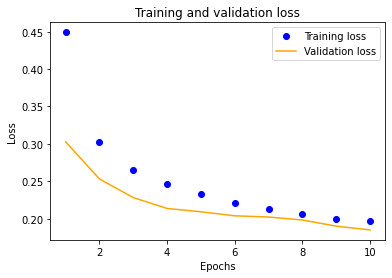

In [0]:
# see the training and validation loss by epoch
history_dict3 = history3.history
loss_values3 = history_dict3['loss'] # you can change this
val_loss_values3 = history_dict3['val_loss'] # you can also change this
epochs3 = range(1, len(loss_values3) + 1) #acc wasn't defined before
plt.plot(epochs3, loss_values3, 'bo', label='Training loss')
plt.plot(epochs3, val_loss_values3, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

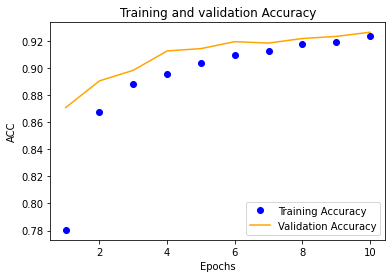

In [0]:
# see the training and validation accuracy by epoch
history_dict3 = history3.history
acc_values3 = history_dict3['acc'] # you can change this
val_acc_values3 = history_dict3['val_acc'] # you can also change this
epochs3 = range(1, len(acc_values3) + 1) #acc wasn't defined before
plt.plot(epochs3, acc_values3, 'bo', label='Training Accuracy')
plt.plot(epochs3, val_acc_values3, 'orange', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

#### Model 3 : Validation Data Result 

In [0]:
preds_val3 = model3.predict(x_val)
# Cut-off Value = 0.5
for i in range(len(preds_val3)):
  if preds_val3[i]>0.5:
    preds_val3[i] = 1
  else:
    preds_val3[i] = 0

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print('Validation Set Confusion Matrix for Model 3')
confusion_matrix(y_val, preds_val3)

Validation Set Confusion Matrix for Model 3


array([[16315,  1258],
       [  943, 11484]])

In [0]:
print(classification_report(y_val, preds_val3))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     17573
           1       0.90      0.92      0.91     12427

    accuracy                           0.93     30000
   macro avg       0.92      0.93      0.92     30000
weighted avg       0.93      0.93      0.93     30000



#### Model 3: Test Data Result

In [0]:
preds_test3 = model3.predict(x_test)
# Cut-off Value = 0.5
for i in range(len(preds_test3)):
  if preds_test3[i]>0.5:
    preds_test3[i] = 1
  else:
    preds_test3[i] = 0

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print('Test Confusion Matrix')
confusion_matrix(y_test, preds_test3)

Test Confusion Matrix


array([[11135,   858],
       [  650,  7853]])

In [0]:
print(classification_report(y_test, preds_test3))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     11993
           1       0.90      0.92      0.91      8503

    accuracy                           0.93     20496
   macro avg       0.92      0.93      0.92     20496
weighted avg       0.93      0.93      0.93     20496



## User Interface

In [0]:
# run the interface
# type this in the terminal
# python chatgui.py